In [2]:
import cv2
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import radon

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from keras.utils.vis_utils import plot_model

# CNN (VGG16)

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [5]:
# Preparar dataset de imágenes redimensionadas al tamaño de entrada del modelo VGG16 (224x224)
image_folder = "Data/PetroImages_v2"
input_size = (224, 224)
image_data = []
image_filenames = []

for fname in os.listdir(image_folder):
    img_path = os.path.join(image_folder, fname)
    img = cv2.imread(img_path)
    if img is not None:
        img_resized = cv2.resize(img, input_size)
        image_data.append(img_resized)
        image_filenames.append(fname)

# Convertir a array de numpy
images_array = np.array(image_data)
print(f"Total imágenes cargadas: {images_array.shape[0]}, Tamaño de cada imagen: {images_array.shape[1:]}")

# Guardar los nombres de archivo
with open("image_filenames.txt", "w") as f:
    for fname in image_filenames:
        f.write(f"{fname}\n")

Total imágenes cargadas: 1735, Tamaño de cada imagen: (224, 224, 3)


In [9]:
# Normalizar el array de imágenes (images_array) a valores entre 0 y 1
images_array_norm = images_array.astype('float32') / 255.0
print(f"Shape: {images_array_norm.shape}, min: {images_array_norm.min()}, max: {images_array_norm.max()}")

Shape: (1735, 224, 224, 3), min: 0.0, max: 1.0


In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Cargar VGG16 preentrenada, sin la última capa (softmax)
base_model = VGG16(weights='imagenet', include_top=True)
# Crear un modelo que termina en la penúltima capa (fc2)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
print(feature_extractor.summary())

553467096/553467096 [==============================] - 9s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [16]:
# Congelar todos los parámetros del modelo feature_extractor
for layer in feature_extractor.layers:
    layer.trainable = False

In [17]:
# Obtener los vectores descriptores para todas las imágenes usando feature_extractor
features = feature_extractor.predict(images_array_norm, verbose=1)
print(f"Shape de los vectores de características: {features.shape}")

55/55 [==============================] - 6s 106ms/step
Shape de los vectores de características: (1735, 4096)


In [ ]:
# Convertir features en un DataFrame con nombres de imágenes y columnas con prefijo 'vg'
vg_columns = [f'vg{i+1}' for i in range(features.shape[1])]
df_vgg16 = pd.DataFrame(features, columns=vg_columns)
df_vgg16['filename'] = image_filenames
df_vgg16.head()

,vg1,vg2,vg3,vg4,vg5,vg6,vg7,vg8,vg9,vg10,...,vg4088,vg4089,vg4090,vg4091,vg4092,vg4093,vg4094,vg4095,vg4096,filename
0,0.0,0.0,1.415101,0.000000,0.713806,0.068249,0.0,0.0,0.406645,0.0,...,1.553566,0.910381,0.490470,0.670551,0.078591,0.337149,0.0,0.0,0.447797,A1Z01F01_000.png
1,0.0,0.0,1.341452,0.267939,0.747261,0.000000,0.0,0.0,0.387894,0.0,...,1.344007,0.961049,0.432159,0.751007,0.022594,0.445291,0.0,0.0,0.368259,A1Z01F02_000.png
2,0.0,0.0,1.333745,0.310070,0.619401,0.010783,0.0,0.0,0.344576,0.0,...,1.457893,0.933471,0.476181,0.761164,0.000000,0.324490,0.0,0.0,0.420148,A1Z01F03_000.png
3,0.0,0.0,1.330524,0.240342,0.699845,0.000000,0.0,0.0,0.396033,0.0,...,1.391132,0.956701,0.414139,0.806762,0.084203,0.426889,0.0,0.0,0.585001,A1Z01F04_000.png
4,0.0,0.0,1.351043,0.114826,0.793674,0.021339,0.0,0.0,0.448845,0.0,...,1.559924,0.898201,0.370686,0.681727,0.122549,0.313742,0.0,0.0,0.488606,A1Z01F05_000.png


In [23]:
df_vgg16.to_csv('df_vgg16_desc.csv', index=False)

## Normalización

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar solo las columnas numéricas (sin la columna 'filename')
radon_columns = [col for col in df_vgg16.columns if col.startswith('Rad')]
scaler = MinMaxScaler()
df_vgg16[vg_columns] = scaler.fit_transform(df_vgg16[vg_columns])

print(df_vgg16.head())

   vg1  vg2       vg3       vg4       vg5       vg6  vg7  vg8       vg9  vg10  \
0  0.0  0.0  0.488752  0.000000  0.502926  0.150679  0.0  0.0  0.572085   0.0   
1  0.0  0.0  0.398708  0.381432  0.549709  0.000000  0.0  0.0  0.543463   0.0   
2  0.0  0.0  0.389284  0.441408  0.370912  0.023807  0.0  0.0  0.477341   0.0   
3  0.0  0.0  0.385346  0.342145  0.483403  0.000000  0.0  0.0  0.555885   0.0   
4  0.0  0.0  0.410434  0.163463  0.614612  0.047113  0.0  0.0  0.636499   0.0   

   ...    vg4088    vg4089    vg4090    vg4091    vg4092    vg4093  vg4094  \
0  ...  0.649281  0.351622  0.344636  0.211273  0.225969  0.311064     0.0   
1  ...  0.330086  0.406242  0.260053  0.290544  0.064964  0.457802     0.0   
2  ...  0.503554  0.376513  0.323910  0.300552  0.000000  0.293888     0.0   
3  ...  0.401866  0.401555  0.233915  0.345479  0.242105  0.432833     0.0   
4  ...  0.658965  0.338493  0.170883  0.222285  0.352360  0.279303     0.0   

   vg4095    vg4096          filename  
0   

In [27]:
# Eliminar columnas de vg_columns donde todos los elementos son 0 en df_vgg16
cols_to_drop = [col for col in vg_columns if (df_vgg16[col] == 0).all()]
df_vgg16 = df_vgg16.drop(columns=cols_to_drop)
print(f"Columnas eliminadas: {cols_to_drop}")
print(df_vgg16.shape)

Columnas eliminadas: ['vg1', 'vg8', 'vg10', 'vg11', 'vg14', 'vg22', 'vg27', 'vg33', 'vg34', 'vg45', 'vg46', 'vg47', 'vg53', 'vg57', 'vg61', 'vg73', 'vg74', 'vg80', 'vg84', 'vg86', 'vg91', 'vg95', 'vg98', 'vg101', 'vg108', 'vg111', 'vg117', 'vg122', 'vg124', 'vg126', 'vg127', 'vg128', 'vg130', 'vg133', 'vg134', 'vg135', 'vg143', 'vg148', 'vg150', 'vg159', 'vg168', 'vg170', 'vg172', 'vg176', 'vg183', 'vg185', 'vg193', 'vg205', 'vg207', 'vg210', 'vg211', 'vg212', 'vg213', 'vg214', 'vg217', 'vg225', 'vg227', 'vg231', 'vg234', 'vg239', 'vg253', 'vg257', 'vg261', 'vg265', 'vg269', 'vg279', 'vg287', 'vg289', 'vg291', 'vg294', 'vg297', 'vg302', 'vg304', 'vg305', 'vg309', 'vg312', 'vg315', 'vg319', 'vg323', 'vg327', 'vg328', 'vg331', 'vg339', 'vg342', 'vg349', 'vg357', 'vg359', 'vg367', 'vg371', 'vg372', 'vg374', 'vg375', 'vg378', 'vg380', 'vg382', 'vg384', 'vg385', 'vg392', 'vg396', 'vg400', 'vg404', 'vg407', 'vg408', 'vg418', 'vg420', 'vg424', 'vg428', 'vg434', 'vg436', 'vg442', 'vg443', 'vg4

In [31]:
vg_columns = [col for col in df_vgg16.columns if col.startswith('vg')]

In [28]:
df_vgg16.describe()

,vg2,vg3,vg4,vg5,vg6,vg7,vg9,vg12,vg13,vg15,...,vg4086,vg4087,vg4088,vg4089,vg4090,vg4091,vg4092,vg4093,vg4095,vg4096
count,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,...,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000
mean,0.000576,0.499293,0.060540,0.515119,0.222822,0.122174,0.529252,0.544444,0.567229,0.417405,...,0.006375,0.302697,0.600807,0.379726,0.471379,0.338712,0.138448,0.483920,0.007907,0.352456
std,0.024008,0.146484,0.120852,0.159015,0.207029,0.186699,0.173108,0.130871,0.175513,0.141753,...,0.060294,0.226661,0.126118,0.130584,0.147685,0.126931,0.179576,0.129581,0.064032,0.126419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.397215,0.000000,0.400710,0.017364,0.000000,0.405550,0.455596,0.438623,0.320214,...,0.000000,0.105599,0.530790,0.291821,0.377149,0.255216,0.000000,0.393499,0.000000,0.271829
50%,0.000000,0.484797,0.000000,0.518190,0.188834,0.000000,0.553765,0.542094,0.571523,0.419946,...,0.000000,0.282845,0.610073,0.371188,0.473165,0.325448,0.052129,0.486048,0.000000,0.342494
75%,0.000000,0.589532,0.070539,0.627707,0.355523,0.195994,0.657083,0.629308,0.707094,0.508101,...,0.000000,0.474176,0.683393,0.451523,0.567334,0.401955,0.235860,0.570807,0.000000,0.420142
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Kmeans

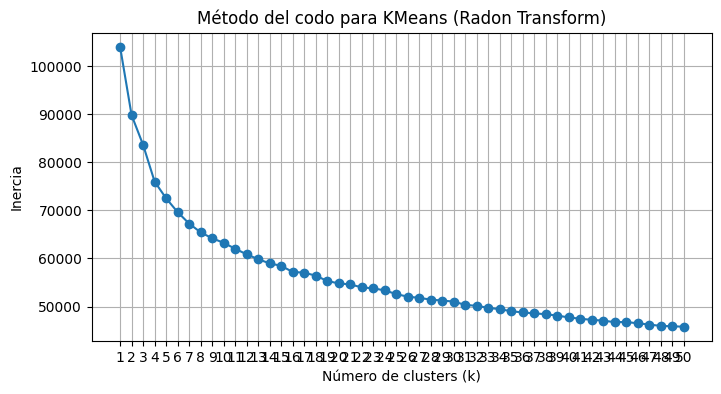

In [33]:
inertia = []
k_range = range(1, 51)
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(df_vgg16[vg_columns])
    inertia.append(kmeans_test.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para KMeans (Radon Transform)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [34]:
# Calcular la varianza explicada acumulada
pca_full = PCA().fit(df_vgg16[vg_columns])
explained_var = np.cumsum(pca_full.explained_variance_ratio_)

# Elegir el número de componentes que explique al menos el 95% de la varianza
n_components_opt = np.argmax(explained_var >= 0.95) + 1
print(f"Número óptimo de componentes principales para 95% de varianza: {n_components_opt}")

# Aplicar PCA con el número óptimo de componentes
pca_opt = PCA(n_components=n_components_opt, random_state=42)
features_pca_opt = pca_opt.fit_transform(df_vgg16[vg_columns])

# Crear DataFrame con los componentes principales y filename
df_vgg16_pca_opt = pd.DataFrame(features_pca_opt, columns=[f'PCA{i+1}' for i in range(n_components_opt)])
df_vgg16_pca_opt['filename'] = df_vgg16['filename'].values

print(df_vgg16_pca_opt.head())

Número óptimo de componentes principales para 95% de varianza: 98
       PCA1      PCA2      PCA3      PCA4      PCA5      PCA6      PCA7  \
0 -3.583339  3.072427 -0.648074  0.871579 -0.209442  3.022234  0.904275   
1 -4.497792  0.471631 -3.707779  0.050542  3.367958  3.801755  1.674909   
2 -4.086627  0.018625 -4.508903  0.347476  2.350567  3.122958  0.473421   
3 -3.926314 -0.137715 -5.364861  0.873026  1.749863  3.292972  0.588180   
4 -4.129988  1.447971 -3.747994 -0.648553  2.603333  3.464087  1.306674   

       PCA8      PCA9     PCA10  ...     PCA90     PCA91     PCA92     PCA93  \
0 -0.397679 -0.776758 -0.816234  ... -0.061914 -0.090491 -0.018334 -0.209596   
1 -2.498242  0.576175  0.318501  ...  0.127105  0.271921  0.263204  0.161361   
2 -2.774228  1.287928 -0.073538  ... -0.154876 -0.148121  0.064191 -0.067983   
3 -2.811033  1.245611  0.067282  ... -0.121562 -0.292594  0.109554  0.066477   
4 -1.441174 -0.050555 -1.952996  ... -0.380391  0.083415  0.026206  0.157973   

  

In [35]:
df_vgg16_pca_opt.describe()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA89,PCA90,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98
count,1.735000e+03,1.735000e+03,1.735000e+03,1735.000000,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,...,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03,1.735000e+03
mean,7.035753e-08,1.758938e-08,3.517876e-08,0.000000,-4.397346e-09,1.758938e-08,-1.319204e-08,-5.276815e-08,3.957611e-08,-1.209270e-08,...,-1.339816e-08,5.221848e-09,-1.099336e-08,3.449168e-08,-6.596018e-09,-1.319204e-08,-1.126820e-08,-7.557937e-09,1.236753e-09,-3.298009e-09
std,3.242814e+00,2.903414e+00,2.458627e+00,2.154374,1.825155e+00,1.685480e+00,1.413206e+00,1.345218e+00,1.196878e+00,1.119352e+00,...,1.847352e-01,1.842472e-01,1.811956e-01,1.790558e-01,1.767581e-01,1.746370e-01,1.726724e-01,1.726605e-01,1.714264e-01,1.689316e-01
min,-8.357342e+00,-1.442513e+01,-7.580234e+00,-7.628623,-5.634436e+00,-5.519041e+00,-4.310102e+00,-7.178767e+00,-4.952976e+00,-4.168787e+00,...,-6.673445e-01,-7.257794e-01,-7.807807e-01,-8.345821e-01,-7.572386e-01,-8.137251e-01,-7.787017e-01,-8.718631e-01,-7.957331e-01,-5.641469e-01
25%,-2.621688e+00,-1.416659e+00,-1.689550e+00,-1.464895,-1.205003e+00,-1.064824e+00,-9.520695e-01,-7.692734e-01,-6.642154e-01,-7.865674e-01,...,-1.164655e-01,-1.159905e-01,-1.182716e-01,-1.112568e-01,-1.042389e-01,-1.048536e-01,-1.074474e-01,-1.112285e-01,-1.089853e-01,-1.033821e-01
50%,-8.000276e-02,4.045690e-01,-9.396584e-02,0.050386,-6.550461e-02,-8.557537e-02,-8.029807e-02,-9.619718e-03,-1.488918e-02,-1.839584e-02,...,2.354840e-03,-1.716979e-03,2.427423e-03,-2.046145e-03,2.570349e-03,2.314012e-03,-1.131888e-03,1.009120e-03,9.125076e-04,-4.631535e-03
75%,2.804342e+00,2.050110e+00,1.791407e+00,1.506962,1.152950e+00,1.045435e+00,8.985143e-01,8.140235e-01,7.048600e-01,7.056025e-01,...,1.101999e-01,1.181355e-01,1.097039e-01,1.126230e-01,1.065318e-01,1.045092e-01,1.007635e-01,1.056389e-01,1.077591e-01,1.050508e-01
max,6.348012e+00,5.563800e+00,8.790330e+00,5.896791,6.348174e+00,6.419451e+00,6.440386e+00,5.197298e+00,4.746004e+00,5.203753e+00,...,7.916840e-01,8.421842e-01,8.259782e-01,9.904101e-01,1.362530e+00,7.011963e-01,1.037930e+00,7.172139e-01,8.267508e-01,7.918942e-01


In [36]:
# Normalizar los componentes principales en df_vgg16_pca_opt (sin la columna 'filename')
scaler_pca = MinMaxScaler()
pca_columns = [col for col in df_vgg16_pca_opt.columns if col.startswith('PCA')]
df_vgg16_pca_opt[pca_columns] = scaler_pca.fit_transform(df_vgg16_pca_opt[pca_columns])

print(df_vgg16_pca_opt.head())

       PCA1      PCA2      PCA3      PCA4      PCA5      PCA6      PCA7  \
0  0.324644  0.875362  0.423453  0.628461  0.452739  0.715440  0.485036   
1  0.262459  0.745250  0.236550  0.567758  0.751288  0.780735  0.556720   
2  0.290419  0.722588  0.187613  0.589712  0.666383  0.723877  0.444959   
3  0.301321  0.714766  0.135327  0.628568  0.616251  0.738118  0.455633   
4  0.287470  0.794095  0.234093  0.516071  0.687477  0.752451  0.522467   

       PCA8      PCA9     PCA10  ...     PCA90     PCA91     PCA92     PCA93  \
0  0.547920  0.430583  0.357700  ...  0.423393  0.429616  0.447261  0.258350   
1  0.378192  0.570076  0.478770  ...  0.543944  0.655171  0.601529  0.433349   
2  0.355892  0.643460  0.436941  ...  0.364105  0.393749  0.492481  0.325156   
3  0.352918  0.639097  0.451966  ...  0.385351  0.303833  0.517337  0.388587   
4  0.463604  0.505457  0.236413  ...  0.220278  0.537850  0.471667  0.431751   

      PCA94     PCA95     PCA96     PCA97     PCA98          filenam

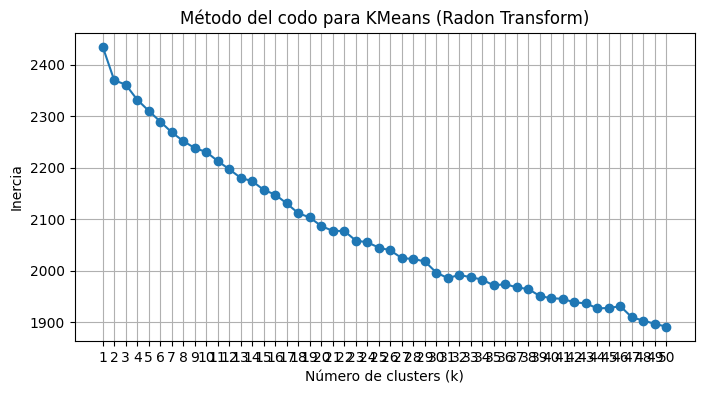

In [37]:
inertia = []
k_range = range(1, 51)
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(df_vgg16_pca_opt[pca_columns])
    inertia.append(kmeans_test.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para KMeans (Radon Transform)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [38]:
best_silhouette = -1
best_db = float('inf')
best_labels = None
best_params = {}

X = df_vgg16_pca_opt[pca_columns]
results = []

for n_clusters in range(3, 50):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    results.append({
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'davies_bouldin': db_index,
        'labels': labels
    })
    if silhouette > best_silhouette or (silhouette == best_silhouette and db_index < best_db):
        best_silhouette = silhouette
        best_db = db_index
        best_labels = labels
        best_params = {'n_clusters': n_clusters}

print(f"Mejor Silhouette: {best_silhouette:.4f}, Mejor Davies-Bouldin: {best_db:.4f}, Parámetros: {best_params}")

# Guardar el mejor clustering en el DataFrame
df_vgg16_pca_opt['kmeans_best'] = best_labels

Mejor Silhouette: 0.0301, Mejor Davies-Bouldin: 4.5338, Parámetros: {'n_clusters': 3}


In [39]:
# Imprimir el número de cluster y la cantidad de imágenes asociadas a cada cluster de kmeans_best
cluster_counts = df_vgg16_pca_opt['kmeans_best'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} imágenes")

Cluster 0: 855 imágenes
Cluster 1: 875 imágenes
Cluster 2: 5 imágenes


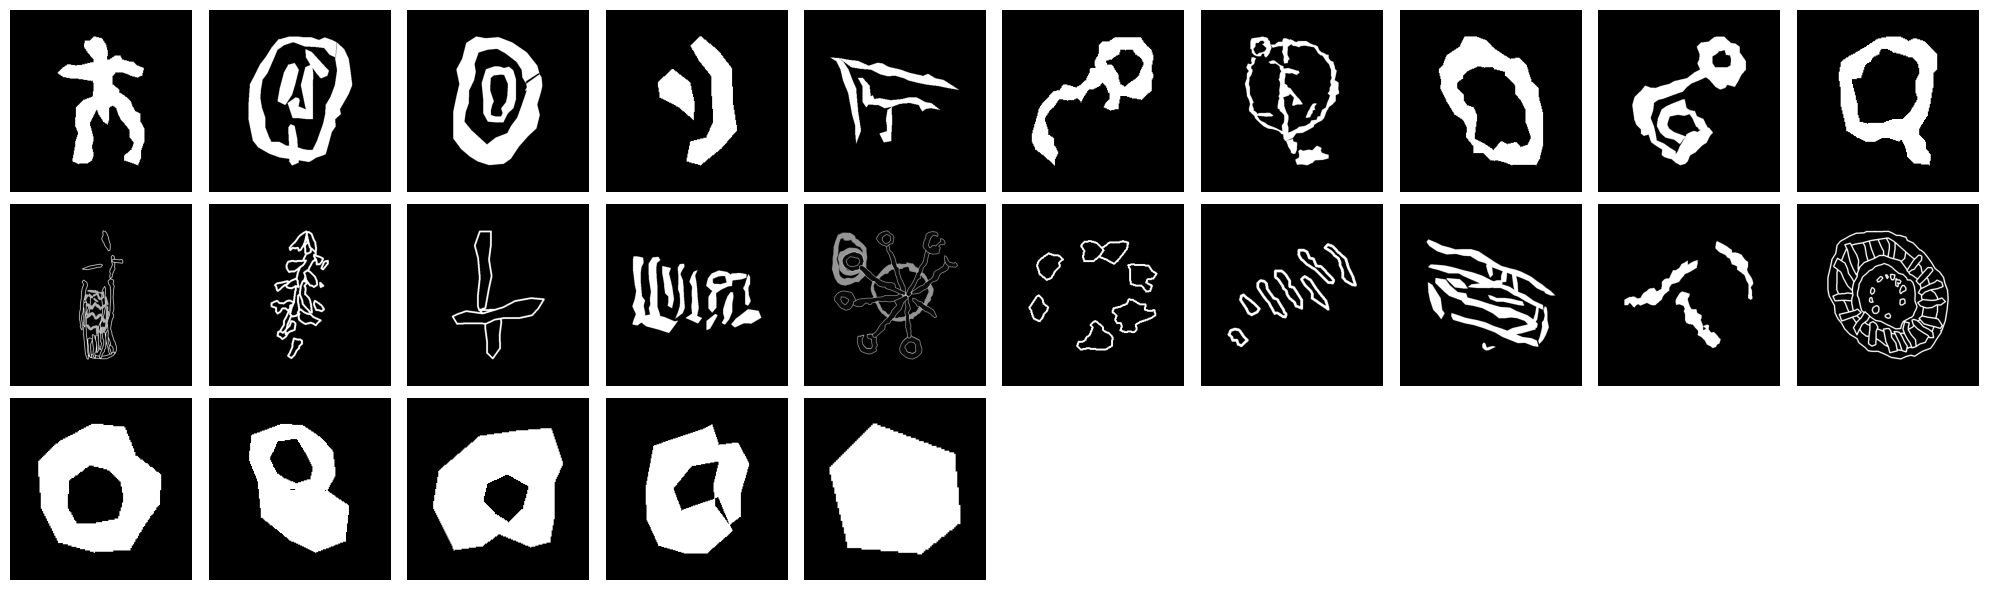

In [40]:
import random
from PIL import Image

num_imgs = 10
clusters_kmeans = df_vgg16_pca_opt['kmeans_best'].unique()
fig, axes = plt.subplots(len(clusters_kmeans), num_imgs, figsize=(num_imgs*2, len(clusters_kmeans)*2))

for idx, cluster_id in enumerate(clusters_kmeans):
    # Filtra las imágenes del cluster actual
    cluster_imgs = df_vgg16_pca_opt[df_vgg16_pca_opt['kmeans_best'] == cluster_id]['filename'].tolist()
    # Selecciona aleatoriamente hasta num_imgs imágenes
    selected_imgs = random.sample(cluster_imgs, min(num_imgs, len(cluster_imgs)))
    for j, fname in enumerate(selected_imgs):
        img_path = os.path.join(image_folder, fname)
        img = Image.open(img_path)
        ax = axes[idx, j] if len(clusters_kmeans) > 1 else axes[j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(f'Cluster {cluster_id}', fontsize=12)
    # Si hay menos de num_imgs imágenes, oculta los ejes restantes
    for j in range(len(selected_imgs), num_imgs):
        ax = axes[idx, j] if len(clusters_kmeans) > 1 else axes[j]
        ax.axis('off')

plt.tight_layout()
plt.show()

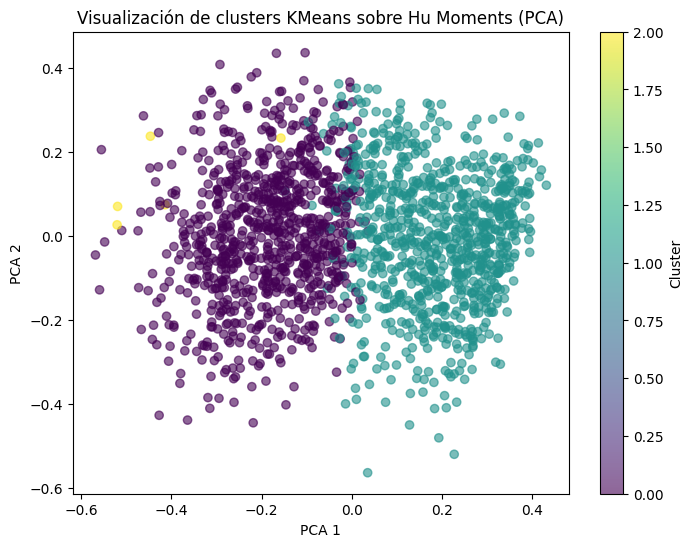

In [42]:
# Reducir la dimensionalidad de los datos normalizados para visualización usando PCA
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(df_vgg16_pca_opt[pca_columns])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=df_vgg16_pca_opt['kmeans_best'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de clusters KMeans sobre Hu Moments (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

# DBSCAN

In [52]:
best_silhouette = -1
best_db = float('inf')
best_labels = None
best_params = {}

X_hu = df_vgg16_pca_opt[pca_columns]

results = []

for eps in [0.1, 0.5, 1, 5, 10]:
    for min_samples in [3, 5, 7]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_hu)
        mask = labels != -1
        n_clusters = len(set(labels[mask]))
        if n_clusters > 1:
            silhouette = silhouette_score(X_hu[mask], labels[mask])
            db_index = davies_bouldin_score(X_hu[mask], labels[mask])
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette': silhouette,
                'davies_bouldin': db_index,
                'labels': labels
            })
            if silhouette > best_silhouette or (silhouette == best_silhouette and db_index < best_db):
                best_silhouette = silhouette
                best_db = db_index
                best_labels = labels
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Mejor Silhouette: {best_silhouette:.4f}, Mejor Davies-Bouldin: {best_db:.4f}, Parámetros: {best_params}")

# Guardar el mejor clustering en el DataFrame
df_vgg16_pca_opt['dbscan_best'] = best_labels

Mejor Silhouette: 0.1698, Mejor Davies-Bouldin: 1.7830, Parámetros: {'eps': 1, 'min_samples': 5}


In [53]:
# Imprimir el número de cluster y la cantidad de imágenes asociadas a cada cluster de dbscan_best
cluster_counts_dbscan = df_vgg16_pca_opt['dbscan_best'].value_counts().sort_index()
for cluster_id, count in cluster_counts_dbscan.items():
    print(f"Cluster {cluster_id}: {count} imágenes")

Cluster -1: 1057 imágenes
Cluster 0: 15 imágenes
Cluster 1: 663 imágenes


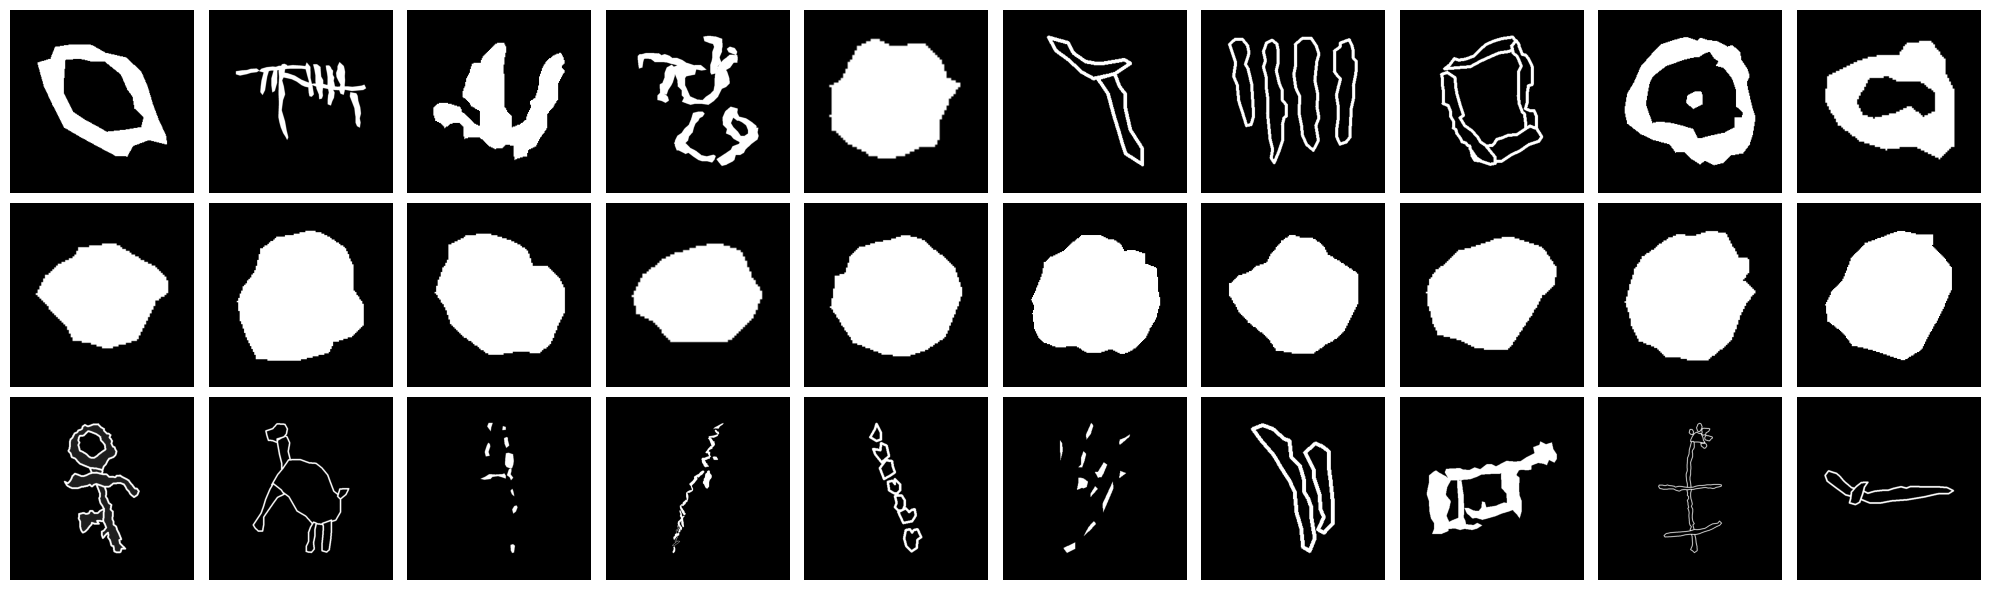

In [58]:
# Selecciona 10 imágenes aleatorias de cada grupo (dbscan_best)
num_imgs = 10
clusters_dbscan = df_vgg16_pca_opt['dbscan_best'].unique()
fig, axes = plt.subplots(len(clusters_dbscan), num_imgs, figsize=(num_imgs*2, len(clusters_dbscan)*2))

for idx, cluster_id in enumerate(clusters_dbscan):
    # Filtra las imágenes del cluster actual
    cluster_imgs = df_vgg16_pca_opt[df_vgg16_pca_opt['dbscan_best'] == cluster_id]['filename'].tolist()
    # Selecciona aleatoriamente hasta num_imgs imágenes
    selected_imgs = random.sample(cluster_imgs, min(num_imgs, len(cluster_imgs)))
    for j, fname in enumerate(selected_imgs):
        img_path = os.path.join(image_folder, fname)
        img = Image.open(img_path)
        ax = axes[idx, j] if len(clusters_dbscan) > 1 else axes[j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(f'Cluster {cluster_id}', fontsize=12)
    # Si hay menos de num_imgs imágenes, oculta los ejes restantes
    for j in range(len(selected_imgs), num_imgs):
        ax = axes[idx, j] if len(clusters_dbscan) > 1 else axes[j]
        ax.axis('off')

plt.tight_layout()
plt.show()

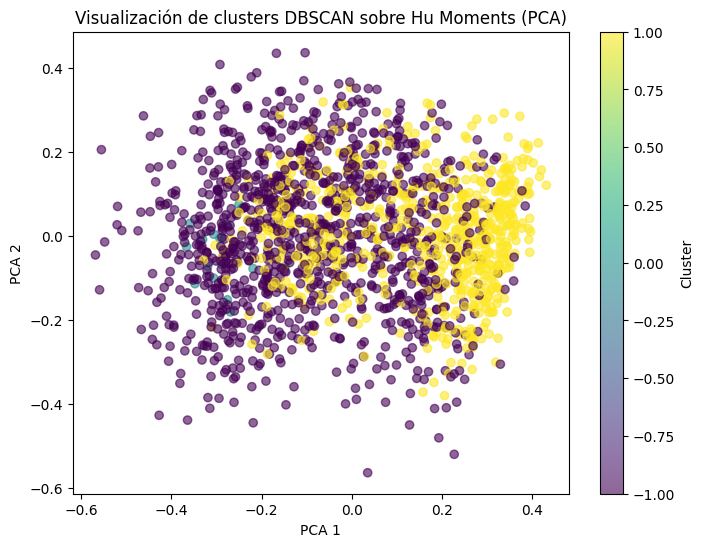

In [59]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(df_vgg16_pca_opt[pca_columns])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=df_vgg16_pca_opt['dbscan_best'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de clusters DBSCAN sobre Hu Moments (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Agglomerative Hierarchical Clustering

In [61]:
best_silhouette = -1
best_db = float('inf')
best_labels = None
best_params = {}

X_hier = df_vgg16_pca_opt[pca_columns]
results_agglo = []

for n_clusters in range(3, 11):
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglo.fit_predict(X_hier)
    silhouette = silhouette_score(X_hier, labels)
    db_index = davies_bouldin_score(X_hier, labels)
    results_agglo.append({
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'davies_bouldin': db_index,
        'labels': labels
    })
    if silhouette > best_silhouette or (silhouette == best_silhouette and db_index < best_db):
        best_silhouette = silhouette
        best_db = db_index
        best_labels = labels
        best_params = {'n_clusters': n_clusters}

print(f"Mejor Silhouette: {best_silhouette:.4f}, Mejor Davies-Bouldin: {best_db:.4f}, Parámetros: {best_params}")

# Guardar el mejor clustering en el DataFrame
df_vgg16_pca_opt['agglo_best'] = best_labels

Mejor Silhouette: 0.0238, Mejor Davies-Bouldin: 4.7872, Parámetros: {'n_clusters': 4}


In [62]:
# Imprimir el número de cluster y la cantidad de imágenes asociadas a cada cluster de dbscan_best
cluster_counts_dbscan = df_vgg16_pca_opt['agglo_best'].value_counts().sort_index()
for cluster_id, count in cluster_counts_dbscan.items():
    print(f"Cluster {cluster_id}: {count} imágenes")

Cluster 0: 855 imágenes
Cluster 1: 765 imágenes
Cluster 2: 80 imágenes
Cluster 3: 35 imágenes


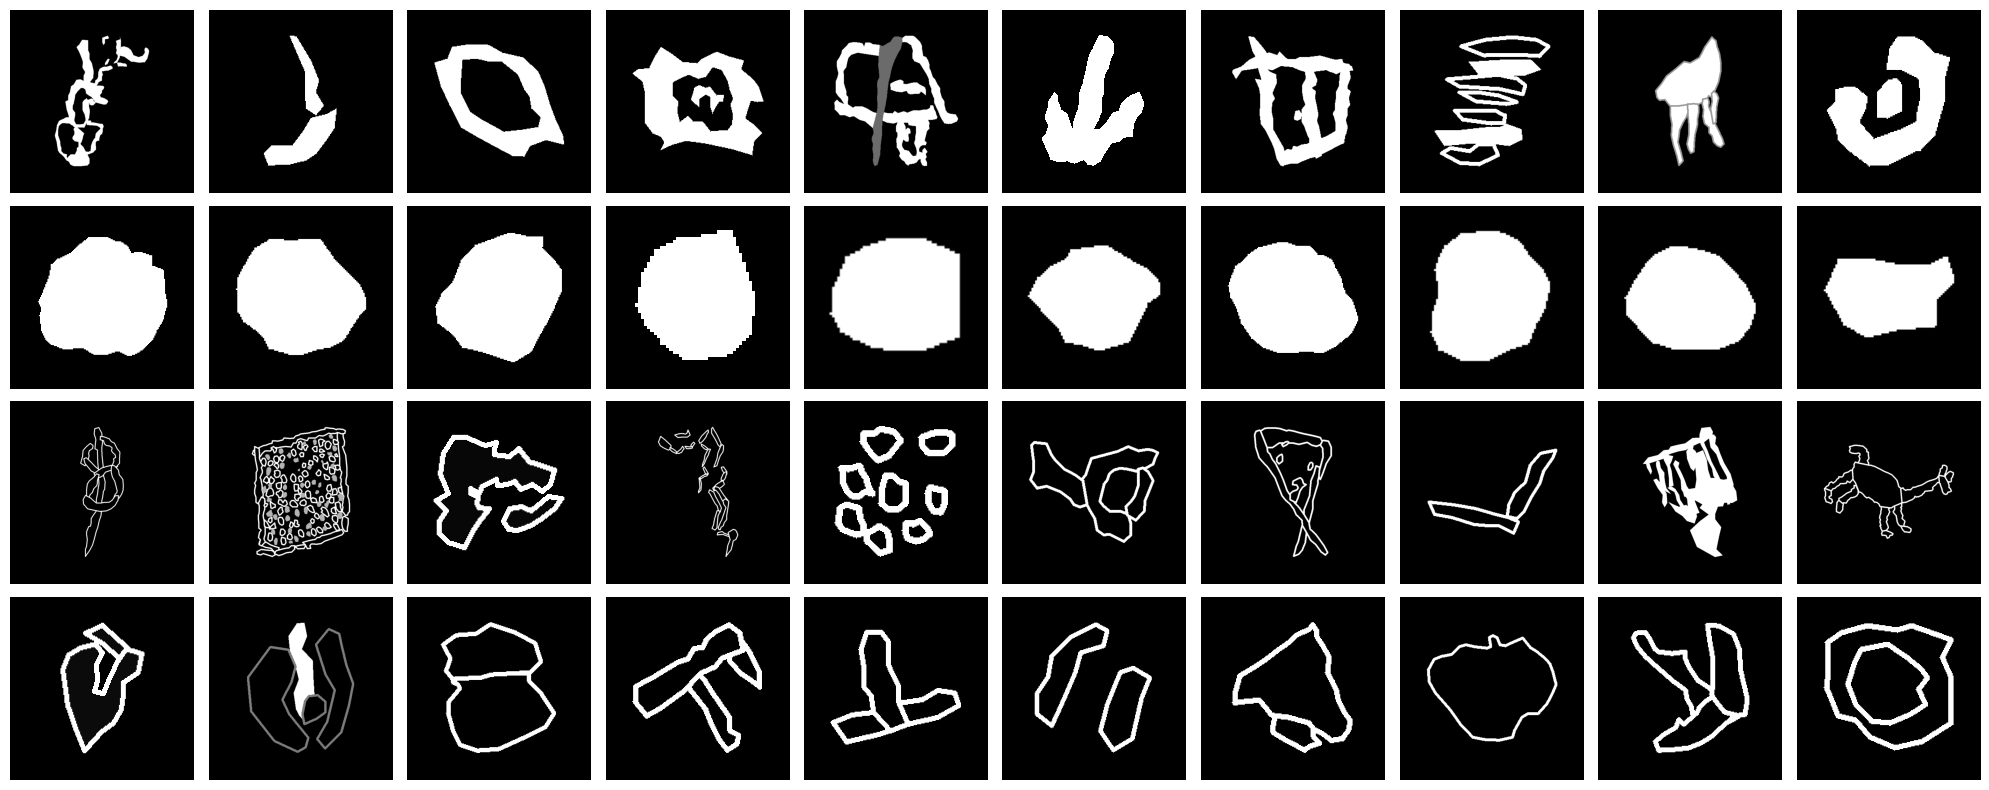

In [64]:
# Selecciona 10 imágenes aleatorias de cada grupo (dbscan_cluster)
num_imgs = 10
clusters_dbscan = df_vgg16_pca_opt['agglo_best'].unique()
fig, axes = plt.subplots(len(clusters_dbscan), num_imgs, figsize=(num_imgs*2, len(clusters_dbscan)*2))

for idx, cluster_id in enumerate(clusters_dbscan):
    # Filtra las imágenes del cluster actual
    cluster_imgs = df_vgg16_pca_opt[df_vgg16_pca_opt['agglo_best'] == cluster_id]['filename'].tolist()
    # Selecciona aleatoriamente hasta num_imgs imágenes
    selected_imgs = random.sample(cluster_imgs, min(num_imgs, len(cluster_imgs)))
    for j, fname in enumerate(selected_imgs):
        img_path = os.path.join(image_folder, fname)
        img = Image.open(img_path)
        ax = axes[idx, j] if len(clusters_dbscan) > 1 else axes[j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(f'Cluster {cluster_id}', fontsize=12)
    # Si hay menos de num_imgs imágenes, oculta los ejes restantes
    for j in range(len(selected_imgs), num_imgs):
        ax = axes[idx, j] if len(clusters_dbscan) > 1 else axes[j]
        ax.axis('off')

plt.tight_layout()
plt.show()

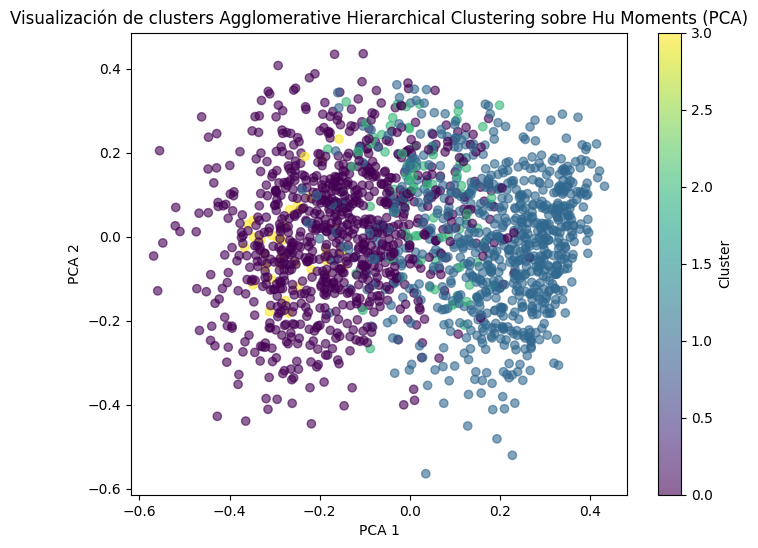

In [65]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(df_vgg16_pca_opt[pca_columns])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=df_vgg16_pca_opt['agglo_best'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de clusters Agglomerative Hierarchical Clustering sobre Hu Moments (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Gaussian Mixture Models (GMM)

In [67]:
best_silhouette = -1
best_db = float('inf')
best_labels = None
best_params = {}

X_gmm = df_vgg16_pca_opt[pca_columns]
results_gmm = []

for n_components in range(3, 11):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(X_gmm)
    silhouette = silhouette_score(X_gmm, labels)
    db_index = davies_bouldin_score(X_gmm, labels)
    results_gmm.append({
        'n_components': n_components,
        'silhouette': silhouette,
        'davies_bouldin': db_index,
        'labels': labels
    })
    if silhouette > best_silhouette or (silhouette == best_silhouette and db_index < best_db):
        best_silhouette = silhouette
        best_db = db_index
        best_labels = labels
        best_params = {'n_components': n_components}

print(f"Mejor Silhouette: {best_silhouette:.4f}, Mejor Davies-Bouldin: {best_db:.4f}, Parámetros: {best_params}")

# Guardar el mejor clustering en el DataFrame
df_vgg16_pca_opt['gmm_best'] = best_labels

Mejor Silhouette: 0.0284, Mejor Davies-Bouldin: 4.5517, Parámetros: {'n_components': 3}


In [68]:
# Imprimir el número de cluster y la cantidad de imágenes asociadas a cada cluster de gmm
cluster_counts_dbscan = df_vgg16_pca_opt['gmm_best'].value_counts().sort_index()
for cluster_id, count in cluster_counts_dbscan.items():
    print(f"Cluster {cluster_id}: {count} imágenes")

Cluster 0: 919 imágenes
Cluster 1: 811 imágenes
Cluster 2: 5 imágenes


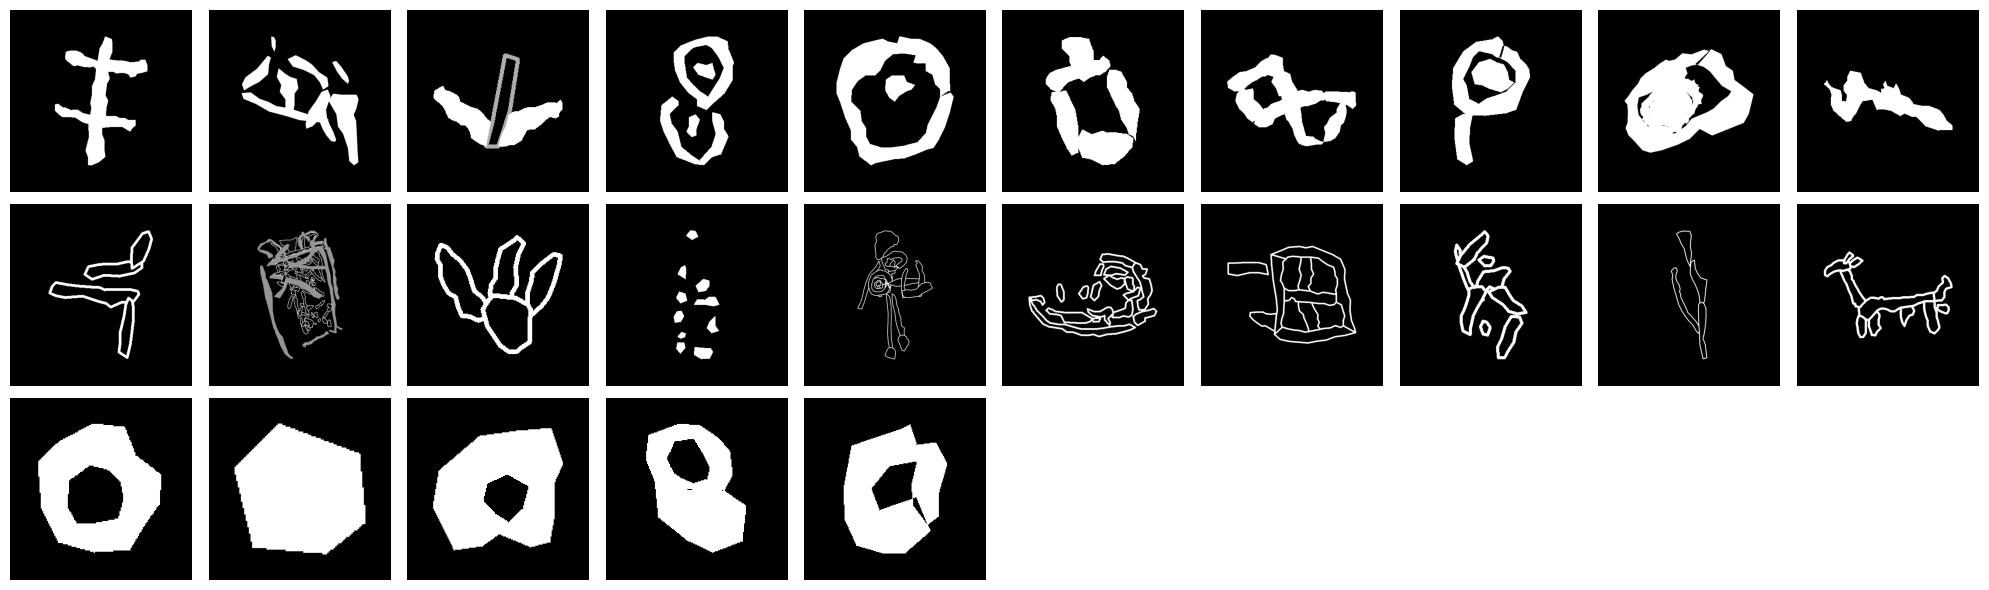

In [69]:
num_imgs = 10
clusters_dbscan = df_vgg16_pca_opt['gmm_best'].unique()
fig, axes = plt.subplots(len(clusters_dbscan), num_imgs, figsize=(num_imgs*2, len(clusters_dbscan)*2))

for idx, cluster_id in enumerate(clusters_dbscan):
    # Filtra las imágenes del cluster actual
    cluster_imgs = df_vgg16_pca_opt[df_vgg16_pca_opt['gmm_best'] == cluster_id]['filename'].tolist()
    # Selecciona aleatoriamente hasta num_imgs imágenes
    selected_imgs = random.sample(cluster_imgs, min(num_imgs, len(cluster_imgs)))
    for j, fname in enumerate(selected_imgs):
        img_path = os.path.join(image_folder, fname)
        img = Image.open(img_path)
        ax = axes[idx, j] if len(clusters_dbscan) > 1 else axes[j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(f'Cluster {cluster_id}', fontsize=12)
    # Si hay menos de num_imgs imágenes, oculta los ejes restantes
    for j in range(len(selected_imgs), num_imgs):
        ax = axes[idx, j] if len(clusters_dbscan) > 1 else axes[j]
        ax.axis('off')

plt.tight_layout()
plt.show()

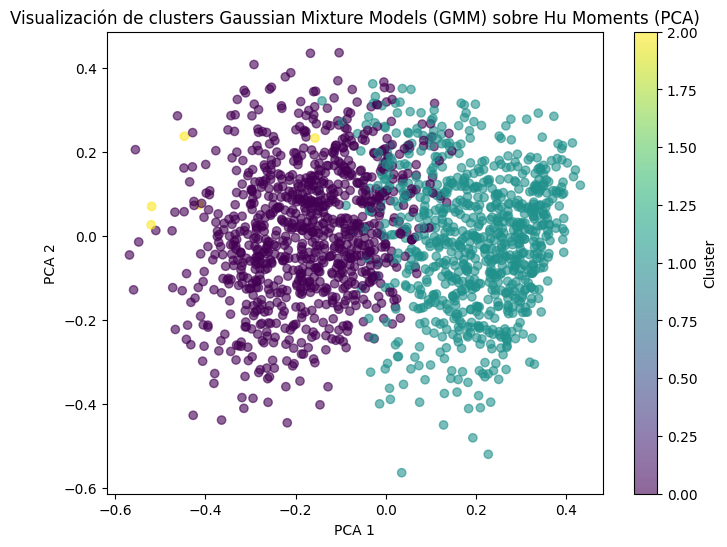

In [70]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(df_vgg16_pca_opt[pca_columns])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=df_vgg16_pca_opt['gmm_best'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualización de clusters Gaussian Mixture Models (GMM) sobre Hu Moments (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()